In [58]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
# from keras.models import load_model

from imblearn.over_sampling import SMOTE
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import pickle
from lightgbm.sklearn import LGBMClassifier

## you'll have to pip install LGBM
# !pip install lightgbm

from sklearn.metrics import roc_curve
from sklearn.metrics import auc


import seaborn as sns
sns.set_style("white")


In [2]:
# data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
# data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);

In [3]:
# data_test__ = data_test[data_test.int_rate != 0.5383972057310751]

In [4]:
# data_test.shape, data_test__.shape

In [5]:
# data_test.columns == data_train.columns

In [6]:
# def split_data(df, cols):
#     x = df.drop(cols, axis = 1)
#     y = df.paid
#     return x, y

# cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 'term_adj', 'zip_code']
# x_train_initial, y_train_initial = split_data(data_train, cols_to_drop_training)
# x_test, y_test = split_data(data_test, cols_to_drop_training)

In [7]:
# sm = SMOTE(random_state=1, ratio = 1.0)
# x_train, y_train = sm.fit_sample(x_train_initial, y_train_initial)

In [8]:
# x_test = x_test.dropna()
# y_test = y_test.dropna()

In [9]:
# with open('Tuned_RF.pkl', 'rb') as file:  
#     rf = pickle.load(file)

# # with open('QDA.pkl', 'rb') as file:  
# #     qda = pickle.load(file, encoding='latin1')

# # with open('Tuned_LGBM.pkl', 'rb') as file:  
# #     lgbm = pickle.load(file, encoding='latin1')

# with open('../anthony/AdaboostGS.pkl', 'rb') as file:  
#     adaboost = pickle.load(file, encoding='latin1')

# with open('../bhaven/Tuned_logReg_all_training_data.pkl', 'rb') as file:  
#     logreg = pickle.load(file, encoding='latin1')

In [10]:
# # models = [rf, qda, lgbm, adaboost, logreg]

In [11]:
# def create_df(data_1, data_2, penal = 0.5):
#     df = pd.DataFrame(data_1)
    
#     df['int_rate'] = data_2['int_rate']
#     df['amnt'] = data_2['amnt']
#     df['total_pymnt'] = data_2['total_pymnt']
#     df['term_adj'] = data_2['term_adj']
#     df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

#     df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term_adj']))-1)
#     df['annualized_amnt'] = df['amnt']*(1/df['term_adj'])
    
#     return df

In [13]:
# distress = data_train[data_train.paid == 1]
# drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
# print(drr)

In [14]:
# train_data = {}
# test_data= {}
# df_train = {}
# df_test = {}

# for model in models:
#     print(model)
#     tr = {'proba' : model.predict_proba(x_train)[:, 1], 
#                          'pred' : model.predict(x_train), 
#                          'true_val' : y_train}
#     df_tr = create_df(tr, data_train)
#     train_data[model] = tr
#     df_train[model] = df_tr
    
#     print(x_test.shape)
#     te = {'proba' : model.predict_proba(x_test)[:, 1], 
#                          'pred' : model.predict(x_test), 
#                          'true_val' : y_test}    
#     print(len(te['proba']))
#     df_te = create_df(te, data_test)    
#     test_data[model] = te
#     df_test[model] = df_te

In [15]:
# with open('df_train_dict.pickle', 'wb') as handle:
#     pickle.dump(df_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('df_test_dict.pickle', 'wb') as handle:
#     pickle.dump(df_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_train_dict.pickle', 'rb') as handle:
    df_train_dict = pickle.load(handle)
with open('df_test_dict.pickle', 'rb') as handle:
    df_test_dict = pickle.load(handle)

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid re

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid re

In [16]:
with open('lgbm_test_no_smote.pickle', 'rb') as handle:
    lgbm_test_dict = pickle.load(handle)
    
with open('lgbm_train_no_smote.pickle', 'rb') as handle:
    lgbm_train_dict = pickle.load(handle)

In [27]:
with open('../bhaven/RF_tuned_test_preds.pickle', 'rb') as handle:
    rf_test_dict = pickle.load(handle)
    
with open('../bhaven/RF_tuned_training_preds.pickle', 'rb') as handle:
    rf_train_dict = pickle.load(handle)

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid re

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invali

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invali

In [29]:
keylgbmtest = list(lgbm_test_dict.keys())[0]
keylgbmtrain = list(lgbm_train_dict.keys())[0]
keyrftest = list(rf_test_dict.keys())[0]
keyrftrain = list(rf_train_dict.keys())[0]
x = list(df_train_dict.keys())[0]
y = list(df_train_dict.keys())[1]
df_train_dict['adaboost'] = df_train_dict.pop(x)
df_train_dict['logreg'] = df_train_dict.pop(y)
x = list(df_test_dict.keys())[0]
y = list(df_test_dict.keys())[1]
df_test_dict['adaboost'] = df_test_dict.pop(x)
df_test_dict['logreg'] = df_test_dict.pop(y)

### PULL TOGETHER ALL DATASETS 

In [34]:
train_preds_lgbm = lgbm_train_dict[keylgbmtrain]
train_preds_adaboost = df_train_dict['adaboost']
train_preds_logreg = df_train_dict['logreg']
train_preds_qda = pd.read_csv('qda_preds_training')
train_preds_nn = pd.read_csv('../hugo/NN_train')
train_preds_rf = rf_train_dict[keyrftrain]


test_preds_lgbm = lgbm_test_dict[keylgbmtest]
test_preds_adaboost = df_test_dict['adaboost']
test_preds_logreg = df_test_dict['logreg']
test_preds_qda = pd.read_csv('qda_preds_test')
test_preds_nn = pd.read_csv('../hugo/NN_test')
test_preds_rf = rf_test_dict[keyrftest]


In [35]:
train_preds_rf.head()

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt
0,0.241625,0,1,0.0699,10400.0,6611.69,3.000000,-0.079855,-1457.484111,3466.666667
1,0.404018,0,0,0.1239,15000.0,17392.37,1.500000,-0.148320,1555.269831,10000.000000
2,0.522240,1,1,0.1366,7650.0,2281.98,3.000000,-0.221908,-2538.540767,2550.000000
3,0.485085,0,0,0.1366,9600.0,9973.43,0.333333,-0.196402,1164.433162,28800.000000
4,0.643480,1,0,0.1559,21425.0,25512.20,1.416667,-0.298256,2810.156493,15123.529412


In [36]:
list_of_model_names = ['Light GBM', 'AdaBoost', 'Logistic Regression', 
                       'Quadratic Discriminant Analysis', 'Neural Network',
                       'Random Forest'
                      ]

list_of_train_dfs = [train_preds_lgbm, 
                     train_preds_adaboost, 
                     train_preds_logreg,
                     train_preds_qda,
                     train_preds_nn,
                     train_preds_rf
                    ]

list_of_test_dfs = [test_preds_lgbm,
                    test_preds_adaboost, 
                    test_preds_logreg,
                    test_preds_qda,
                    test_preds_nn, 
                    test_preds_rf
                   ]

In [37]:
# train_preds_rf.head()

In [38]:
### delete the bad data with 0.567 for all rows
for key, df in enumerate(list_of_train_dfs):
    df = df[df.int_rate < 0.5]
for key, df in enumerate(list_of_test_dfs):
    df = df[df.int_rate < 0.5]

## NOW MAKE PRETTY THINGS :

- Get accuracy for each of the models
- Get ROC for each of the models
- Get ROC plots for each of the models

In [39]:
roc_auc_score_training = []
accuracy_training = []

for train_df in list_of_train_dfs:
    
    roc_auc_score_training.append(roc_auc_score(train_df['true_val'], train_df['proba']))
    accuracy_training.append(accuracy_score(train_df['true_val'], train_df['pred']))

In [40]:
roc_auc_score_testing = []
accuracy_testing = []
for test_df in list_of_test_dfs:
    
    roc_auc_score_testing.append(roc_auc_score(test_df['true_val'], test_df['proba']))
    
    accuracy_testing.append(accuracy_score(test_df['true_val'], test_df['pred']))

In [41]:
display_model_results = pd.DataFrame(
    {'Training Accuracy' : accuracy_training,
     'Training AUC' : roc_auc_score_training, 
     'Test Accuracy' : accuracy_testing,
     'Test AUC' : roc_auc_score_testing
    }, index = list_of_model_names)

display_model_results = display_model_results.sort_values(by = 'Test AUC', ascending=0)
display_model_results.round(2)

,Training Accuracy,Training AUC,Test Accuracy,Test AUC
Logistic Regression,0.65,0.71,0.75,0.72
Neural Network,0.56,0.67,0.72,0.72
Light GBM,0.79,0.70,0.70,0.64
Random Forest,0.69,0.72,0.72,0.64
AdaBoost,0.90,0.96,0.66,0.62
Quadratic Discriminant Analysis,0.53,0.53,0.78,0.50


In [60]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(train_preds_lgbm['true_val'], 
                                                train_preds_lgbm['proba'])
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(train_preds_logreg['true_val'], 
                                                      train_preds_logreg['proba'])
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(train_preds_adaboost['true_val'], 
                                                            train_preds_adaboost['proba'])
auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

fpr_qda, tpr_qda, thresholds_qda = roc_curve(train_preds_qda['true_val'], 
                                             train_preds_qda['proba'])
auc_qda = auc(fpr_qda, tpr_qda)

fpr_nn, tpr_nn, thresholds_nn = roc_curve(train_preds_nn['true_val'], 
                                          train_preds_nn['proba'])
auc_nn = auc(fpr_nn, tpr_nn)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(train_preds_rf['true_val'], 
                                          train_preds_rf['proba'])
auc_rf = auc(fpr_rf, tpr_rf)

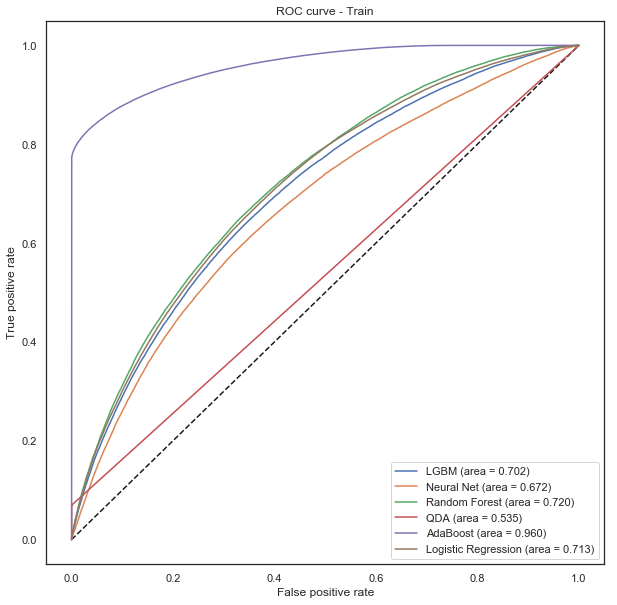

In [61]:
fig = plt.figure(figsize = (10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgbm, tpr_lgbm, label='{} (area = {:.3f})'.format('LGBM',auc_lgbm))
plt.plot(fpr_nn, tpr_nn, label='{} (area = {:.3f})'.format('Neural Net',auc_nn))
plt.plot(fpr_rf, tpr_rf, label='{} (area = {:.3f})'.format('Random Forest',auc_rf))
plt.plot(fpr_qda, tpr_qda, label='{} (area = {:.3f})'.format('QDA',auc_qda))
plt.plot(fpr_adaboost, tpr_adaboost, label='{} (area = {:.3f})'.format('AdaBoost',auc_adaboost))
plt.plot(fpr_logreg, tpr_logreg, label='{} (area = {:.3f})'.format('Logistic Regression',auc_logreg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Train')
plt.legend(loc='best')
plt.show()

In [55]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(test_preds_lgbm['true_val'], 
                                                test_preds_lgbm['proba'])
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(test_preds_logreg['true_val'], 
                                                      test_preds_logreg['proba'])
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(test_preds_adaboost['true_val'], 
                                                            test_preds_adaboost['proba'])
auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

fpr_qda, tpr_qda, thresholds_qda = roc_curve(test_preds_qda['true_val'], 
                                             test_preds_qda['proba'])
auc_qda = auc(fpr_qda, tpr_qda)

fpr_nn, tpr_nn, thresholds_nn = roc_curve(test_preds_nn['true_val'], 
                                          test_preds_nn['proba'])
auc_nn = auc(fpr_nn, tpr_nn)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_preds_rf['true_val'], 
                                          test_preds_rf['proba'])
auc_rf = auc(fpr_rf, tpr_rf)

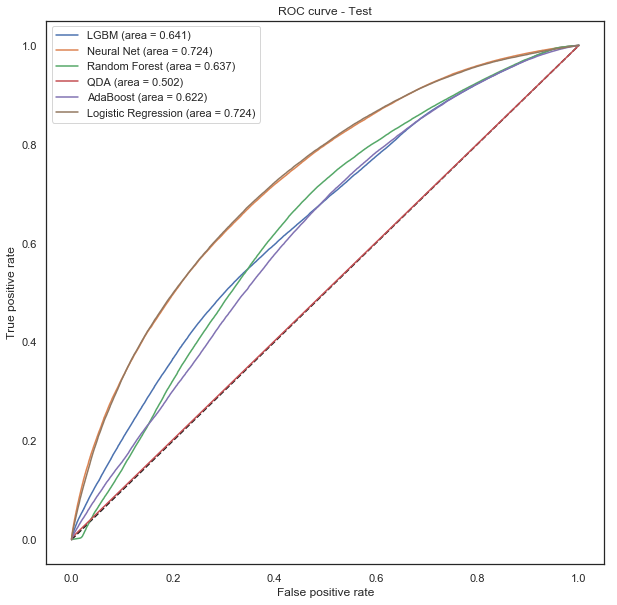

In [59]:
fig = plt.figure(figsize = (10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgbm, tpr_lgbm, label='{} (area = {:.3f})'.format('LGBM',auc_lgbm))
plt.plot(fpr_nn, tpr_nn, label='{} (area = {:.3f})'.format('Neural Net',auc_nn))
plt.plot(fpr_rf, tpr_rf, label='{} (area = {:.3f})'.format('Random Forest',auc_rf))
plt.plot(fpr_qda, tpr_qda, label='{} (area = {:.3f})'.format('QDA',auc_qda))
plt.plot(fpr_adaboost, tpr_adaboost, label='{} (area = {:.3f})'.format('AdaBoost',auc_adaboost))
plt.plot(fpr_logreg, tpr_logreg, label='{} (area = {:.3f})'.format('Logistic Regression',auc_logreg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test')
plt.legend(loc='best')
plt.show()

In [ ]:
# # train_data[model] = {'proba' : model.predict_proba(x_train)[:, 1], 'pred' : model.predict(x_train), 'true_val' : y_train}
# # test_data = {'proba' : rf_complex.predict_proba(x_test)[:, 1], 'pred' : rf_complex.predict(x_test),  'true_val' : y_test}

# df_train = create_df(train_data, data_train)
# df_test =  create_df(test_data, data_test)

In [ ]:
# baseline_train = np.mean(df_train.ROI)
# baseline_test = np.mean(df_test.ROI)
# print(baseline_train, baseline_test)
# alpha_low = 0
# alpha_high = -np.inf

In [ ]:
# print(roc_auc_score(df_train.true_val, df_train.pred))
# print(roc_auc_score(df_test.true_val, df_test.pred))

In [ ]:
# print(np.sum(df_train.true_val)/df_train.shape[0])
# print(1 - np.sum(df_test.true_val)/df_test.shape[0])

In [ ]:
# loans_to_buy_train = df_train[(df_train.ROI > alpha_low*baseline_train) & (df_train.ROI < alpha_high*baseline_train)]
# loans_to_buy_test = df_test[(df_test.ROI > alpha_low*baseline_test) & (df_test.ROI < alpha_high*baseline_test)]

In [ ]:
# def return_performance(df_sub, df_main):
#     perf_subset = np.sum(df_sub.Real_ROI)/np.sum(df_sub.annualized_amnt)
#     perf_mainset = np.sum(df_main.Real_ROI)/np.sum(df_main.annualized_amnt)
#     return (perf_subset, perf_mainset, perf_subset - perf_mainset)

In [ ]:
# training_set_performance = return_performance(loans_to_buy_train, df_train)
# testing_set_performance = return_performance(loans_to_buy_test, df_test)

In [ ]:
# fig = plt.figure(figsize=(15,6));
# ax = plt.subplot(1,1,1);

# ax.hist(df_test.loc[df_test.true_val == 0,'proba'], density = True, bins = 50, label='Paid Off', alpha=0.6);
# ax.hist(df_test.loc[df_test.true_val == 1,'proba'], density = True, bins = 50, label='Defaulted', alpha=0.5);
# ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
# ax.legend(loc='best')

# plt.show()

In [ ]:
# fig = plt.figure(figsize=(15,6));
# ax = plt.subplot(1,1,1);

# ax.hist(df_train.loc[df_train.true_val == 0,'proba'], bins = 50, label='Paid Off', alpha=0.6);
# ax.hist(df_train.loc[df_train.true_val == 1,'proba'], bins = 50, label='Defaulted', alpha=0.5);
# ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
# ax.legend(loc='best')

# plt.show()

In [ ]:
# sns.kdeplot(df_train.loc[df_train.true_val == 0,'proba'], label = 'Paid Out');
# sns.kdeplot(df_train.loc[df_train.true_val == 1,'proba'], label = 'Defaulted');

In [ ]:
# sns.set(rc={'figure.figsize':(16,8)})
# sns.kdeplot(df_test.loc[df_test.true_val == 0,'proba'], label = 'Paid Out');
# sns.kdeplot(df_test.loc[df_test.true_val == 1,'proba'], label = 'Defaulted', linestyle='--');
# plt.ylim(0, 3)
# plt.xlim(0, 1);
# plt.xlabel('Probability of Default', size = 15);
# plt.ylabel('Density of Distributions', size = 15);
# plt.legend(prop={'size': 13});
# plt.savefig('default_probability_distribution.png', bbox_inches='tight')

In [ ]:
# sns.kdeplot(df_test['ROI'], label = '2015 Data');
# sns.kdeplot(df_train['ROI'], label = '2014 Data', linestyle='--');
# plt.ylim(0, 5)
# plt.xlim(-0.5, 0.1);
# plt.xlabel('Predicted Return on Investment', size = 15);
# plt.ylabel('Density of Distributions', size = 15);
# plt.legend(prop={'size': 13});
# plt.savefig('ROI_distribution.png', bbox_inches='tight')